<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Merge_dataset_Network_classification_hystology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Prove mettendo insieme i due dataset. Partendo da un unico dataset e dividendolo usando train_test_split.





In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [2]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_labels = df_train.Histology

In [0]:
test_labels = df_test.Histology

In [0]:
tot_data = pd.concat([train_data, test_data], axis=0)

In [13]:
train_data.shape

(131, 107)

In [14]:
test_data.shape

(34, 107)

In [15]:
tot_data.shape

(165, 107)

In [16]:
tot_data

,VoxelVolume,Maximum3DDiameter,MeshVolume,MajorAxisLength,Sphericity,LeastAxisLength,Elongation,SurfaceVolumeRatio,Maximum2DDiameterSlice,Flatness,SurfaceArea,MinorAxisLength,Maximum2DDiameterColumn,Maximum2DDiameterRow,GrayLevelVariance,HighGrayLevelEmphasis,DependenceEntropy,DependenceNonUniformity,GrayLevelNonUniformity,SmallDependenceEmphasis,SmallDependenceHighGrayLevelEmphasis,DependenceNonUniformityNormalized,LargeDependenceEmphasis,LargeDependenceLowGrayLevelEmphasis,DependenceVariance,LargeDependenceHighGrayLevelEmphasis,SmallDependenceLowGrayLevelEmphasis,LowGrayLevelEmphasis,JointAverage,SumAverage,JointEntropy,ClusterShade,MaximumProbability,Idmn,JointEnergy,Contrast,DifferenceEntropy,InverseVariance,DifferenceVariance,Idn,...,10Percentile,Kurtosis,Mean,ShortRunLowGrayLevelEmphasis,GrayLevelVariance.1,LowGrayLevelRunEmphasis,GrayLevelNonUniformityNormalized,RunVariance,GrayLevelNonUniformity.1,LongRunEmphasis,ShortRunHighGrayLevelEmphasis,RunLengthNonUniformity,ShortRunEmphasis,LongRunHighGrayLevelEmphasis,RunPercentage,LongRunLowGrayLevelEmphasis,RunEntropy,HighGrayLevelRunEmphasis,RunLengthNonUniformityNormalized,GrayLevelVariance.2,ZoneVariance,GrayLevelNonUniformityNormalized.1,SizeZoneNonUniformityNormalized,SizeZoneNonUniformity,GrayLevelNonUniformity.2,LargeAreaEmphasis,SmallAreaHighGrayLevelEmphasis,ZonePercentage,LargeAreaLowGrayLevelEmphasis,LargeAreaHighGrayLevelEmphasis,HighGrayLevelZoneEmphasis,SmallAreaEmphasis,LowGrayLevelZoneEmphasis,ZoneEntropy,SmallAreaLowGrayLevelEmphasis,Coarseness,Complexity,Strength,Contrast.1,Busyness
0,51905.377962,66.288317,51847.748274,50.574214,0.649258,37.884620,0.821088,0.199752,63.135672,0.749090,10356.675894,41.525899,65.067279,55.325619,12.481889,1084.854684,5.949646,918.046673,5312.127441,0.122582,97.652454,0.050648,141.807349,0.124010,42.380287,163828.301666,0.000266,0.001208,33.190463,66.380925,4.331076,-475.448161,0.308299,0.994676,0.133643,8.029403,2.169232,0.424312,6.065116,0.967009,...,-75.0,17.777521,5.650502,0.001166,17.478141,0.001372,0.192540,1.399893,2288.112500,3.749302,793.234742,6675.859117,0.776723,4220.221337,0.654950,0.003806,4.209293,1049.544424,0.560736,34.869500,42116.076135,0.060025,0.517739,1145.238698,132.775769,42183.224231,540.316964,0.122035,36.510775,4.877236e+07,751.520796,0.747563,0.002453,5.741322,0.001663,0.000357,928.016789,1.153806,0.020920,1.306338
1,13432.502747,58.057539,13312.697411,48.354803,0.572236,18.135097,0.546338,0.356577,40.146103,0.375042,4747.006589,26.418066,32.760898,56.652510,60.615944,1076.589137,7.130906,595.667519,351.846858,0.307871,239.202712,0.126873,32.011715,0.031426,12.612334,41890.348882,0.001812,0.003214,33.522040,67.044080,7.487967,-2829.110940,0.055759,0.985695,0.015596,38.337756,3.408960,0.322015,23.246287,0.935189,...,-397.0,5.224099,-91.310969,0.003404,65.432452,0.003524,0.064158,0.230922,262.139314,1.567042,926.829706,3237.676584,0.908183,1777.017297,0.869059,0.004164,5.072184,1044.275778,0.790377,84.615342,598.216508,0.033349,0.543736,843.878866,51.757732,607.367912,543.633876,0.330564,0.465530,8.137725e+05,763.567010,0.764879,0.006307,6.451087,0.004959,0.001680,2944.805484,2.266070,0.146173,0.253533
2,25843.872675,52.918217,25724.437234,39.406474,0.675497,28.487740,0.891907,0.242519,46.415213,0.722920,6238.658603,35.146929,47.180420,46.322906,55.064124,1131.900166,6.932158,844.783490,1023.136953,0.253452,192.059998,0.093605,57.855402,0.045979,22.286238,79266.271357,0.000812,0.001864,34.046184,68.092368,6.796695,-3133.512010,0.106695,0.984515,0.033042,32.375097,3.182144,0.362633,21.028555,0.936889,...,-363.0,5.387644,-67.724986,0.001973,61.733697,0.002096,0.085594,0.426431,626.125860,1.968083,906.575851,5266.417163,0.870954,2393.005796,0.809077,0.002930,4.968901,1079.567623,0.718481,68.928494,3157.415098,0.036760,0.531612,1319.991542,91.276279,3170.626259,525.709823,0.275125,2.306913,4.377395e+06,732.877970,0.757392,0.003456,6.294554,0.002520,0.000745,2146.780339,1.238883,0.152919,0.611772
3,22152.7

In [0]:
tot_label = pd.concat([train_labels, test_labels], axis=0)

In [18]:
tot_label.shape

(165,)

##Train test split

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
train_data, test_data, train_labels, test_labels = train_test_split(tot_data, tot_label,
                                                  stratify=tot_label, test_size=0.25, random_state=1) 


##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in train_labels]

In [0]:
test_labels_dec = [word_index[label] for label in test_labels]

In [24]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

##Z score dei dati

In [0]:
mean = train_data.mean(axis=0)
train_data_stand = train_data - mean
std = train_data.std(axis=0)
train_data_stand /= std

In [0]:
test_data_stand = test_data - mean
test_data_stand /= std

In [28]:
test_labels_dec.count(0)

9

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.9, svd_solver='full')

In [31]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [33]:
train_data_stand_pca.shape

(123, 9)

#Building Network

In [0]:
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(5, activation='relu', input_shape=(9,)))

#  model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.01, momentum=0.4, nesterov=True)
  
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [40]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_pca, train_labels_dec)

10

In [41]:
for train_index, test_index in skf.split(train_data_stand_pca, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  36  38
  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  57  58
  59  61  62  63  64  65  66  67  69  70  71  72  73  74  76  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118 120
 121 122] TEST: [ 19  35  37  41  56  60  68  75  77  78  94 110 119]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37  38
  39  41  43  44  45  46  47  48  49  50  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  71  72  73  74  75  76  77  78
  79  80  81  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120] TEST: [ 11  13  33  40  42  51

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
import keras

In [45]:
num_epochs = 20
all_acc_histories = []
all_loss_histories = []
all_val_acc_histories = []
all_val_loss_histories = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  model = build_model()
  history = model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history = history.history['acc']
  all_acc_histories.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  acc_val_history = history.history['val_acc']
  all_val_acc_histories.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 110 samples, validate on 13 samples
Epoch 1/20





110/110 [==============================] - 0s 2ms/step - loss: 1.5017 - acc: 0.4000 - val_loss: 1.4330 - val_acc: 0.3077
Epoch 2/20
110/110 [==============================] - 0s 178us/step - loss: 1.2060 - acc: 0.4182 - val_loss: 1.3452 - val_acc: 0.3846
Epoch 3/20
110/110 [==============================] - 0s 177us/step - loss: 1.0951 - acc: 0.4182 - val_loss: 1.3219 - val_acc: 0.3077
Epoch 4/20
110/110 [==============================] - 0s 222us/step - loss: 1.0418 - acc: 0.4182 - val_loss: 1.2875 - val_acc: 0.2308
Epoch 5/20
110/110 [==============================] - 0s 148us/step - loss: 1.0055 - acc: 0.4000 - val_loss: 1.2787 - val_acc: 0.3077
Epoch 6/20
110/110 [==============================] - 0s 165us/step - loss: 0.9854 - acc: 0.4182 - val_loss: 1.2906 - val_acc: 0.3077
Epoch 7/20
110/110 [==========================

In [0]:
history_dict = history.history

In [47]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [48]:
len(all_acc_histories[2])

20

In [0]:
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]


In [50]:
len(average_val_acc_history)

20

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

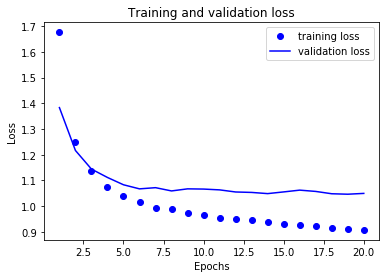

In [53]:
plt.plot(epochs, average_loss_history, 'bo', label='training loss')
plt.plot(epochs, average_val_loss_history, 'b', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

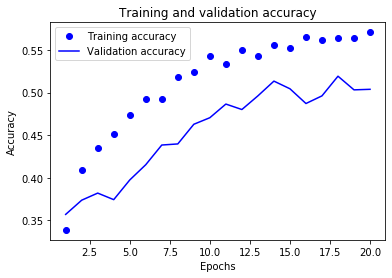

In [54]:
plt.plot(epochs, average_acc_history, 'bo', label='Training accuracy')
plt.plot(epochs, average_val_acc_history, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

#Performances on test set

In [55]:
 model = build_model()
 model.fit(train_data_stand_pca, one_hot_train_labels, epochs= num_epochs, batch_size=8, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_pca, one_hot_test_labels)
  

Epoch 1/20
123/123 [==============================] - 0s 3ms/step - loss: 2.0964 - acc: 0.2846
Epoch 2/20
123/123 [==============================] - 0s 179us/step - loss: 1.3584 - acc: 0.3659
Epoch 3/20
123/123 [==============================] - 0s 165us/step - loss: 1.1604 - acc: 0.4309
Epoch 4/20
123/123 [==============================] - 0s 166us/step - loss: 1.0775 - acc: 0.4715
Epoch 5/20
123/123 [==============================] - 0s 179us/step - loss: 1.0320 - acc: 0.5285
Epoch 6/20
123/123 [==============================] - 0s 152us/step - loss: 0.9960 - acc: 0.5610
Epoch 7/20
123/123 [==============================] - 0s 185us/step - loss: 0.9668 - acc: 0.5528
Epoch 8/20
123/123 [==============================] - 0s 149us/step - loss: 0.9531 - acc: 0.5610
Epoch 9/20
123/123 [==============================] - 0s 160us/step - loss: 0.9326 - acc: 0.6016
Epoch 10/20
123/123 [==============================] - 0s 161us/step - loss: 0.9265 - acc: 0.5854
Epoch 11/20
123/123 [==========

In [56]:
model.metrics_names

['loss', 'acc']

In [57]:
test_acc


0.33333333475249155

#Prova con LDA

##LDA

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
lda = LinearDiscriminantAnalysis()

In [0]:
train_data_stand_lda = lda.fit(train_data_stand, train_labels_dec).transform(train_data_stand)

In [127]:
train_data_stand_lda.shape

(123, 2)

In [0]:
test_data_stand_lda = lda.transform(test_data_stand)

##Building Network

In [0]:
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(5, activation='relu', input_shape=(2,)))
  #model.add(layers.Dense(7, activation='relu'))
  #model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.001, momentum=0.5)
  
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

##Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [131]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_lda, train_labels_dec)

10

In [132]:
for train_index, test_index in skf.split(train_data_stand_lda, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  36  38
  39  40  42  43  44  45  46  47  48  49  50  51  52  53  54  55  57  58
  59  61  62  63  64  65  66  67  69  70  71  72  73  74  76  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  95  96  97  98  99 100
 101 102 103 104 105 106 107 108 109 111 112 113 114 115 116 117 118 120
 121 122] TEST: [ 19  35  37  41  56  60  68  75  77  78  94 110 119]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  10  12  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  34  35  36  37  38
  39  41  43  44  45  46  47  48  49  50  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  71  72  73  74  75  76  77  78
  79  80  81  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 106 107 108 109 110 111 112 113 114 115 116 117 118
 119 120] TEST: [ 11  13  33  40  42  51

In [0]:
#train_labels_dec[125]

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
import keras

In [139]:
num_epochs = 30
all_acc_histories_lda = []
all_loss_histories_lda = []
all_val_acc_histories_lda = []
all_val_loss_histories_lda = []

for train_index, val_index in skf.split(train_data_stand_lda, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_lda[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_lda[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  model = build_model()
  history = model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history = history.history['acc']
  all_acc_histories_lda.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories_lda.append(loss_history)

  acc_val_history = history.history['val_acc']
  all_val_acc_histories_lda.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories_lda.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 110 samples, validate on 13 samples
Epoch 1/30
110/110 [==============================] - 3s 27ms/step - loss: 1.3050 - acc: 0.2727 - val_loss: 1.0822 - val_acc: 0.3846
Epoch 2/30
110/110 [==============================] - 0s 253us/step - loss: 1.0760 - acc: 0.2273 - val_loss: 0.9121 - val_acc: 0.5385
Epoch 3/30
110/110 [==============================] - 0s 217us/step - loss: 0.9287 - acc: 0.5364 - val_loss: 0.8013 - val_acc: 0.6923
Epoch 4/30
110/110 [==============================] - 0s 210us/step - loss: 0.8271 - acc: 0.6818 - val_loss: 0.7257 - val_acc: 0.6923
Epoch 5/30
110/110 [==============================] - 0s 204us/step - loss: 0.7565 - acc: 0.7636 - val_loss: 0.6685 - val_acc: 0.7692
Epoch 6/30
110/110 [==============================] - 0s 219us/step - loss: 0.7041 - acc: 0.7909 - val_loss: 0.6274 - val_acc: 0.7692
Epoch 7/30
110/110 [==============================] - 0s 261us/step - loss: 0.6651 - acc: 0.8091 - val_loss: 0.5938 - val_acc: 0.8462
Epoch 8/30
110/110

In [76]:
val_data

array([[ 0.94892679, -3.26204263],
       [ 3.6902765 ,  1.91193691],
       [ 4.33888855,  3.11923441],
       [-0.19375808, -1.99141129],
       [ 4.92020805,  2.60198864],
       [-0.11763691, -3.08731746],
       [ 0.27541973, -3.58936325],
       [ 4.10074676,  2.79547975],
       [ 0.81236067, -4.18441726],
       [ 4.62588055,  1.71410556],
       [-8.20314863,  2.62258764],
       [-7.82534822,  2.32665836]])

In [0]:
history_dict = history.history

In [78]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [79]:
len(all_acc_histories[2])

20

In [0]:
average_acc_history_lda = [np.mean([x[i] for x in all_acc_histories_lda]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history_lda = [np.mean([x[i] for x in all_loss_histories_lda]) for i in range(num_epochs)]
average_val_acc_history_lda = [np.mean([x[i] for x in all_val_acc_histories_lda]) for i in range(num_epochs)]
average_val_loss_history_lda = [np.mean([x[i] for x in all_val_loss_histories_lda]) for i in range(num_epochs)]


In [91]:
len(average_val_acc_history)

20

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

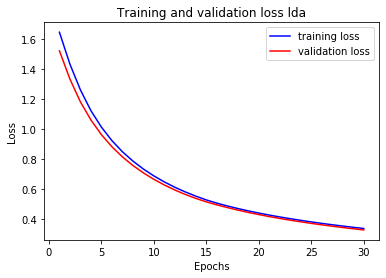

In [142]:
plt.plot(epochs, average_loss_history_lda, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history_lda, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

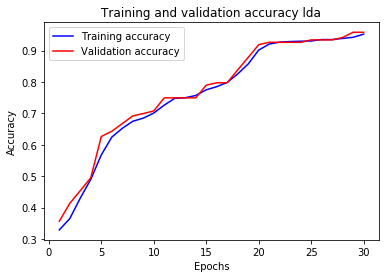

In [143]:
plt.plot(epochs, average_acc_history_lda, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history_lda, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [144]:
 model = build_model()
 model.fit(train_data_stand_lda, one_hot_train_labels, epochs= num_epochs, batch_size=8, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_lda, one_hot_test_labels)
  

Epoch 1/30
123/123 [==============================] - 3s 22ms/step - loss: 2.8252 - acc: 0.2195
Epoch 2/30
123/123 [==============================] - 0s 220us/step - loss: 2.3365 - acc: 0.2195
Epoch 3/30
123/123 [==============================] - 0s 200us/step - loss: 1.9180 - acc: 0.2195
Epoch 4/30
123/123 [==============================] - 0s 207us/step - loss: 1.5573 - acc: 0.2195
Epoch 5/30
123/123 [==============================] - 0s 235us/step - loss: 1.2681 - acc: 0.2195
Epoch 6/30
123/123 [==============================] - 0s 194us/step - loss: 1.0489 - acc: 0.2439
Epoch 7/30
123/123 [==============================] - 0s 192us/step - loss: 0.8919 - acc: 0.5854
Epoch 8/30
123/123 [==============================] - 0s 220us/step - loss: 0.7897 - acc: 0.6098
Epoch 9/30
123/123 [==============================] - 0s 245us/step - loss: 0.7205 - acc: 0.6098
Epoch 10/30
123/123 [==============================] - 0s 235us/step - loss: 0.6716 - acc: 0.6098
Epoch 11/30
123/123 [=========

In [96]:
model.metrics_names

['loss', 'acc']

In [145]:
test_acc


0.33333333617164973